# Molecular Potential Prediction using Pre-trained EGNN and Transformer-Encoder

This notebook is used to record the complete process and workflow of data-processing, model architecture creation, model training/fine-tuning. Some utility functions were encapsulated in the models folder in the [[GitHub Repository]](https://github.com/Curtis-Wu/Equivariant-Graph-Transformer), which will not be shown in this file.

The goal of this project is to achieve accurate molecular potential prediction for the ANI-1 data set. But the functionality of the model should be able to generalize molecular properties prediction accurately to other datasets such as ANI-1x, QM9 etc. This was achieved by using end-to-end training/prediction, ie. not using hand-crafted molecular descriptors/features such as Atomic Environment Vectors (AEV) as described in the [[2017 Paper]](https://pubs.rsc.org/en/content/articlelanding/2017/sc/c6sc05720a).

The model presented in this repository use a [(Pre-trained)](https://pubs.acs.org/doi/10.1021/acs.jctc.3c00289) [E(n) equivariant neural network](https://arxiv.org/abs/2102.09844), which becomes invariant in our case when dealing with objects with static positions, as well as an transformer encoder to capture both the local and global interactions between the point clouds to achieve molecular properties predictions accurately.

## <b>Sections</b>

1. [Model Architecture](#model)<br>
      <i>[Equivariant Graph Convolutional Layers](#egcl)<br></i>
      <i>[Transformer Encoder](#tf)<br></i>
      <i>[Final Model](#final)<br></i>
2. [Data Reading and Pre-Processing](#data)
3. [Trainer Class](#trainer)
4. [Model Training/Prediction](#training/prediction)
5. [Results](#results)

## <b>Model Architecture</b><a name="model"></a>

### <i>Helper Functions and Preliminary Imports</i>

In [ ]:
import os
import gc
import csv
import time
import yaml
import math
import json
import shutil
import numpy as np
from copy import deepcopy
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.multiprocessing
import torch.nn.functional as F
from torch.optim import AdamW
from torch_scatter import scatter
from torch_cluster import radius_graph
from torch.utils.tensorboard import SummaryWriter
torch.multiprocessing.set_sharing_strategy('file_system')


def unsorted_segment_sum(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result

def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

def single_head_attention(q, k, v):
    # attention(q, k, v) = softmax(qK.T/sqrt(dk)V)
    d_k = q.size()[-1] # 64
    # Only transpose the last 2 dimensions, because the first dimension is the batch size
    # scale the value with square root of d_k which is a constant value
    val_before_softmax = torch.matmul(q, k.transpose(-1,-2))/math.sqrt(d_k)
    attention = F.softmax(val_before_softmax, dim = -1) # 200 x 200
    # Multiply attention matrix with value matrix
    values = torch.matmul(attention, v) # 200 x 64
    return values, attention

### <i>Equivariant Graph Convolutional Layer (EGCL)</i><a name="egcl"></a>

Message passed from node j to i, with $\|{x^l_i-x^l_j}\|^2$ being the radial distance between the node coordinates:
 $$m_{ij} = \phi_e(h^l_i,h^l_j, \|{x^l_i-x^l_j}\|^2,a_{ij})$$
Aggregated message passed from all neighbor nodes j of node i: 
$$m_i=\sum_{j\in N(i)}m_{ij}$$
Node Embeddings Update: 
$$h^{l+1}_i=\phi_h(h^l_i,m_i)$$


In [3]:
class E_GCL(nn.Module):
    """
    E(n) Equivariant Convolutional Layer
    Reference: EGNN: V. G. Satorras et al., https://arxiv.org/abs/2102.09844 
    """
    def __init__(
        self, input_nf, output_nf, hidden_nf, add_edge_feats=0, act_fn=nn.SiLU(), 
        residual=True, attention=False, normalize=False, coords_agg='mean', static_coord = True
    ):
        '''
        :param intput_nf: Number of input node features
        :param output_nf: Number of output node features
        :param hidden_nf: Number of hidden node features
        :param add_edge_feats: Number of additional edge feature
        :param act_fn: Activation function
        :param residual: Use residual connections
        :param attention: Whether using attention or not
        :param normalize: Normalizes the coordinates messages such that:
                    instead of: x^{l+1}_i = x^{l}_i + Σ(x_i - x_j)phi_x(m_ij)
                    we get:     x^{l+1}_i = x^{l}_i + Σ(x_i - x_j)phi_x(m_ij)/||x_i - x_j||
        :param coords_agg: aggregation function
        '''
        super(E_GCL, self).__init__()
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.static_coord = static_coord
        self.coords_agg = coords_agg
        # Number of features used to describe the relative positions between nodes
        # Because we're using radial distance, so dimension = 1
        edge_coords_nf = 1
        # input_edge stores the node values, one edge connects two nodes, so * 2
        input_edge = input_nf * 2
        # Prevents division by zeroes, numerical stability purpose
        self.epsilon = 1e-8
        # mlp operation for edges
        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edge_coords_nf + add_edge_feats, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)
        # mlp operation for nodes
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        layer = nn.Linear(hidden_nf, 1, bias=False)
        # Initializes layer weights using xavier uniform initialization
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        # Update coodinates
        if not static_coord:
            # coordinates mlp sequntial layers
            coord_mlp = []
            coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))
            coord_mlp.append(act_fn)
            coord_mlp.append(layer)
        
        # attention mlp layer
        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())
            
    def edge_model(self, source, target, radial, edge_feats):
        # concatenation of edge features
        if edge_feats is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1)
        else:
            # Dimension analysis:
            # eg. source, target -> (num_edges, num_node_features)
            # radial -> (num_edges, 1)
            # edge_feats -> (num_edges, 3)
            # out -> (num_edges, num_node_features*2 + 1 + 3)
            out = torch.cat([source, target, radial, edge_feats], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_feats, node_attr = None):
        # Dimension analysis:
        # x -> (num_nodes, num_node_features)
        # edge_index -> (2, num_edges)
        # edge_feats -> (num_edges, num_edge_feats)

        # unpacks source and target nodes from edge_index
        row, col = edge_index
        # unsorted_segment_sum sums up all edge features for each node
        # agg dimension -> (num_nodes, num_edge_feats)
        agg = unsorted_segment_sum(edge_feats, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        if self.residual:
            out = x + out
        return out, agg

    # Coordinates update function, this calculation is not used when static_coord is True
    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        if self.coords_agg == 'sum':
            agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        elif self.coords_agg == 'mean':
            agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        else:
            raise Exception('Wrong coords_agg parameter' % self.coords_agg)
        coord += agg
        return coord

    def coord2radial(self, edge_index, coord):
        # unpacks source and target nodes from edge_index
        row, col = edge_index
        # calculate coordinate difference between node
        coord_diff = coord[row] - coord[col]
        # calculate the radial distance for each pair of node
        radial = torch.sum(coord_diff**2, 1).unsqueeze(1)
        # normalization
        if self.normalize:
            norm = torch.sqrt(radial).detach() + self.epsilon
            coord_diff = coord_diff / norm

        return radial, coord_diff

    def forward(self, h, edge_index, coord, add_edge_feats=None, node_attr=None):
        # unpacks source and target nodes from edge_index
        row, col = edge_index
        # calculate radial distances for each pair of node
        radial, coord_diff = self.coord2radial(edge_index, coord)
        # Compute edge features
        edges = self.edge_model(h[row], h[col], radial, add_edge_feats)

        # Update coordinates
        if not self.static_coord:
            coord = self.coord_model(coord, edge_index, coord_diff, add_edge_feats)
            
        # Update node features
        h, agg = self.node_model(h, edge_index, edges, node_attr)

        return h, add_edge_feats

### <i>Transformer Encoder</i><a name="tf"></a>

$$Attention(Q,K,V)=softmax\frac{QK^T}{\sqrt{d_k}}V$$
$$MultiHead(Q,K,V)=Concat(head_1,...,head_h)W^O\space where head_i=Attention(QW^Q_i,KW^K_i,VW^V_i)$$

In [4]:
class EncoderLayer(nn.Module):
    """
    Attention is All you Need
    Reference: A. Vaswani et al., https://arxiv.org/abs/1706.03762
    """
    def __init__(self, d_model, num_heads, num_ffn, dropout_r, act_fn_ecd):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model = d_model, num_heads = num_heads)
        self.norm1 = LayerNormalization(parameters_shape = [d_model])
        self.dropout = nn.Dropout(p = dropout_r)
        self.ffn = MLP(d_model = d_model, num_ffn = num_ffn, act_fn = act_fn_ecd, dropout_r = dropout_r)
        self.norm2 = LayerNormalization(parameters_shape = [d_model])
        self.act_fn = act_fn_ecd

    def forward(self, x):
        # Input value that's untouched and will be added to normalization layer
        residual_x = x
        # Calcualte self-attention matrix
        x = self.attention(x)
        # Dropout
        x = self.dropout(x)
        # Add residual_x to x and normalize
        x = self.norm1(x + residual_x)
        # Create another untouched residual input x
        residual_x = x
        # Pass to the feedforward neural network
        x = self.ffn(x)
        # Dropout
        x = self.dropout(x)
        # Add residual_x to the x and normalize again
        x = self.norm2(x + residual_x)
        # Output of encoder layer
        return x

# Multi-head attention class
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model                              # for example 256
        self.num_heads = num_heads                          # for example for 8 heads
        self.head_dim = d_model // num_heads                # head_dim will be 32
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)    # 256 x 768
        self.linear_layer = nn.Linear(d_model, d_model)     # 256 x 256

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(0)  # Add a batch dimension at the front

        batch_size, sequence_length, d_model = x.size()     # for example 30 x 200 x 512
        qkv = self.qkv_layer(x) # 30 x 200 x 1536
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim) # 30 x 200 x 8 x 96
        qkv = qkv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 96, switch 8 and 200
        q, k, v = qkv.chunk(3, dim = -1) # breakup using the last dimension, each are 30 x 8 x 200 x 32

        values, attention = single_head_attention(q, k, v)
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)

        out = self.linear_layer(values)

        return out
        
# Layer normalization
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps = 1e-8):
        super().__init__()
        self.eps = eps # to take care of zero division
        self.parameters_shape = parameters_shape
        self.gamma = nn.Parameter(torch.ones(parameters_shape)) # learnable parameter "std" (256,)
        self.beta = nn.Parameter(torch.zeros(parameters_shape)) # learnable parameter "mean" (256,)

    def forward(self, inputs):
        dims = [-(i+1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim = dims, keepdim = True) # eg. for (30, 200, 256) inputs, mean -> (30, 200, 1)
        var = ((inputs - mean)**2).mean(dim = dims, keepdim = True) # (30, 200, 1) 
        std = (var + self.eps).sqrt() # (30, 200, 1)
        y = (inputs - mean) / std # Normalized output (30, 200, 512)
        out = self.gamma*y + self.beta # Apply learnable parameters

        return out

# Feedforward MLP
class MLP(nn.Module):
    def __init__(self, d_model, num_ffn, act_fn, dropout_r = 0.1):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(d_model, num_ffn)
        self.linear2 = nn.Linear(num_ffn, d_model)
        self.act_fn = act_fn
        self.dropout = nn.Dropout(p = dropout_r)

    def forward(self, x):
        x = self.linear1(self.act_fn(x))
        x = self.dropout(x)
        x = self.linear2(self.act_fn(x))

        return x

### <b><i>Final Model: Equivariant Graph Transformer</i></b><br><a name="final"></a>

The use of Equivariant Graph Convolutional Layers (EGCL) is to capture or simulate local intramolecular interactions between the atoms while preserving equivariant (in this case invariant) properties. The use of a transformer encoder is to capture long-range interaction between different regions of the molecule without extensive numbers of EGCL layes. Positional embeddings were not used since in this case the node embeddings does not contain any positional or sequence information.

<i>Note: The naming of the model was proposed for simplicity reasons. The model presented is not a Graph-Transformer in a traditional meaning, which utilizes transformer architecture to perform calculation directly on graph data (Nodes + Edges).</i>

![Diagram of the model architecture](./images/architecture.png)

In [5]:
class EGTF(nn.Module):
    def __init__(self, # EGNN/EGCL parameters
                 hidden_channels, num_edge_feats, num_egcl, 
                 act_fn = nn.SiLU(), residual = True, attention = True,
                 normalize = False, max_atom_type = 100, cutoff = 5.0,
                 max_num_neighbors = 32, static_coord = True, freeze_egcl = True,
                 # Transformer-Encoder parameters
                 d_model = 256, num_encoder = 1, num_heads = 8,
                 num_ffn = 256, act_fn_ecd = nn.SiLU(), dropout_r = 0.1,
                 # Energy Head parameter
                 num_neurons = 512):

        super(EGTF, self).__init__()
        # self.hidden_channels = hidden_channels
        self.n_layers = num_egcl
        # self.max_atom_type = max_atom_type
        self.cutoff = cutoff
        self.max_num_neighbors = max_num_neighbors
        # Create embeddings of dimension (hidden_channels, ) for each atom type
        self.type_embedding = nn.Embedding(max_atom_type, hidden_channels)
        
        # EGC layers
        for i in range(0, num_egcl):
            self.add_module("gcl_%d" % i, E_GCL(
                input_nf = hidden_channels, 
                output_nf = hidden_channels, 
                hidden_nf = hidden_channels, 
                add_edge_feats = num_edge_feats,
                act_fn = act_fn, residual = residual, 
                attention = attention, normalize = normalize,
                static_coord = static_coord))
            
        # Whether or not to freeze parameters of pre-trained egnn
        if freeze_egcl:
            for i in range(num_egcl - 1):
                layer_name = f"gcl_{i}"
                for param in getattr(self, layer_name).parameters():
                    param.requires_grad = False
                    
        # Transformer-Encoder layers
        self.encoder_layers = \
            nn.ModuleList([EncoderLayer(d_model, num_heads,
                                        num_ffn, dropout_r, act_fn_ecd) 
                                        for _ in range(num_encoder)])

        # Energy Head
        self.energy_fc = nn.Sequential(
            nn.Linear(d_model, num_neurons),
            act_fn_ecd,
            nn.Linear(num_neurons, 1)
        )

    def forward(self, z, pos, batch, edge_index=None, edge_feats=None):
        h = self.type_embedding(z)
        x = deepcopy(pos)

        if edge_index is None:
            # Calculates edge_index from graph structure based on cutoff radius
            edge_index = radius_graph(
                pos,
                r=self.cutoff,
                batch=batch,
                loop=False,
                max_num_neighbors=self.max_num_neighbors + 1,
            )
        # EGC layers
        for i in range(0, self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edge_index, x, add_edge_feats=edge_feats)
        # Encoder layers
        for layer in self.encoder_layers:
            h = layer(h)
        # Energy Head
        h = h.squeeze(0)  # Assuming the batch dimension is at dim 0
        h = scatter(h, batch, dim=0, reduce='add')
        
        out = self.energy_fc(h)

        return out        

## <b>Data Reading and Pre-Processing</b><a name="data"></a>

### Workflow Explained:
For complete pre-processing of data, 
1) `ANI1Wrapper` class will be created, which takes in batch size, num_workers, validation set size, test set size, data directory path, and seed as arguments. It will first utilize `anidataloader` function to read in and store all atom coordinates, types and energies. Then it will split all data into training, validation, and test set using the specified values. 

    ```
    self.train_species.extend([S] * len(train_idx))
    self.train_energies.append(E[train_idx])
    for i in train_idx:
        self.train_positions.append(X[i])
    ```
    The atoms will be the same for each molecule, for example for water which is `['H','H','O']` and 3 conformations, we would create a list of `[['H''H','O'], ['H','H','O'], ['H','H','O']]` using `extend`.<br>`self.train_energies` will be a 1D list which holds the energies for each conformation.<br>`self.train_positions` will be a list of lists for example `X = [[pos1], [pos2], [pos3]]`.
2) The splitted data would then be used to create `class ANI1(Dataset)`, which is a pre-processed Dataset class used for `torch_geometric.DataLoader`. When called, `class ANI1(Dataset)` will prepare encoded atom types (convention followed from the original E(n) EGNN paper), coordinates, and compensated energies (record energy - self interaction energy) into pytorch tensors batch-wise.
3) Data loaders were created using `PyGDataLoader/torch_geometric.DataLoader` with parameters such as `num_workers`, `shuffle`, and `drop_last`. The meanings of these parameters were explained in inline documentation. `train_loader`, `valid_loader`, `test_loader` were returned, which are ready to be used by the Trainer class.

In [6]:
from models.utils import anidataloader
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader

In [7]:
class ANI1Wrapper(object):
    def __init__(self, batch_size, num_workers, valid_size, test_size, data_dir, seed):
        super(object, self).__init__()
        """
        batch_size: training batch size
        num_workers: Number of subprocesses to use for data loading, controls the parallelism
        valid_size: validation set percentage
        test_size: test set percentage
        data_dir: file path for the Data directory
        seed: random seed
        """
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.valid_size = valid_size
        self.test_size = test_size
        self.seed = seed

    def get_data_loaders(self):
        random_state = np.random.RandomState(seed=self.seed)
        # read all data with that ends wit hh5
        hdf5files = [f for f in os.listdir(self.data_dir) if f.endswith('.h5')]

        n_mol = 0 # to record the total number of molecules/conformations
        self.train_species, self.valid_species, self.test_species = [], [], []
        self.train_positions, self.valid_positions, self.test_positions = [], [], []
        self.train_energies, self.valid_energies, self.test_energies = [], [], []
        self.test_smiles = []
        
        for f in hdf5files:
            print('reading:', f)
            h5_loader = anidataloader(os.path.join(self.data_dir, f))
            for data in h5_loader:
                # Get coordinates, atom types, energies, smiles
                X = data['coordinates']
                S = data['species']
                E = data['energies']
                # get the total number of conformations
                n_conf = E.shape[0]
                # create a list of indices and randomly shuffle them
                indices = list(range(n_conf))
                random_state.shuffle(indices)
                # calculate the split points for training, validation, and test data
                split1 = int(np.floor(self.valid_size * n_conf))
                split2 = int(np.floor(self.test_size * n_conf))
                # split indices to 3
                valid_idx, test_idx, train_idx = \
                    indices[:split1], indices[split1:split1+split2], indices[split1+split2:]

                # Record atom types, training energies, and positions for the 3 datasets
                self.train_species.extend([S] * len(train_idx))
                self.train_energies.append(E[train_idx])
                for i in train_idx:
                    self.train_positions.append(X[i])
                
                self.valid_species.extend([S] * len(valid_idx))
                self.valid_energies.append(E[valid_idx])
                for i in valid_idx:
                    self.valid_positions.append(X[i])
                
                self.test_species.extend([S] * len(test_idx))
                self.test_energies.append(E[test_idx])
                for i in test_idx:
                    self.test_positions.append(X[i])

                n_mol += 1
            
            h5_loader.cleanup()
        
        # Merge all lists of lists from all files into a single array
        self.train_energies = np.concatenate(self.train_energies, axis=0)
        self.valid_energies = np.concatenate(self.valid_energies, axis=0)
        self.test_energies = np.concatenate(self.test_energies, axis=0)

        print("# molecules:", n_mol)
        print("# train conformations:", len(self.train_species))
        print("# valid conformations:", len(self.valid_species))
        print("# test conformations:", len(self.test_species))

        train_dataset = ANI1(
            self.data_dir, species=self.train_species,
            positions=self.train_positions, energies=self.train_energies
        )
        valid_dataset = ANI1(
            self.data_dir, species=self.valid_species,
            positions=self.valid_positions, energies=self.valid_energies
        )
        test_dataset = ANI1(
            self.data_dir, species=self.test_species, 
            positions=self.test_positions, energies=self.test_energies, 
            # smiles=self.test_smiles
        )

        """
        num_workers: specifies how many subprocesses to use for data loading. It controls the parallelism of data loading
        shuffle: determines whether the data should be shuffled at every epoch, turned on for training and off for others
        drop_last: controls whether the last batch should be dropped in case it is smaller than the specified batch_size
        pin_memory: when set to True, enables the DataLoader to use pinned memory for faster data transfer to CUDA-enabled GPUs
        persistent_workers: control whether the worker processes of the DataLoader should be kept alive across multiple iterations
        """
        train_loader = PyGDataLoader(
            train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, 
            shuffle=True, drop_last=True, 
            pin_memory=True, persistent_workers=True
        )
        valid_loader = PyGDataLoader(
            valid_dataset, batch_size=self.batch_size, num_workers=self.num_workers, 
            shuffle=False, drop_last=True, 
            pin_memory=True, persistent_workers=True
        )
        test_loader = PyGDataLoader(
            test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, 
            shuffle=False, drop_last=False
        )

        del self.train_species, self.valid_species, self.test_species
        del self.train_positions, self.valid_positions, self.test_positions
        del self.train_energies, self.valid_energies, self.test_energies

        return train_loader, valid_loader, test_loader

# Note: this encoding notation is followed from the original paper
ATOM_DICT = {('C', 0): 3, ('Cl', 0): 7, ('F', 0): 9, ('H', 0): 10, ('N', 0): 17,
            ('O', 0): 21, ('S', 0): 26}
SELF_INTER_ENERGY = {
    'H': -0.500607632585, 
    'C': -37.8302333826,
    'N': -54.5680045287,
    'O': -75.0362229210
}

class ANI1(Dataset):
    def __init__(self, data_dir, species, positions, energies):
        self.data_dir = data_dir
        self.species = species
        self.positions = positions
        self.energies = energies

    def __getitem__(self, index):
        # get the position, atoms, and energie for one conformation
        # Index automatically handlled by PyGDataLoader
        pos = self.positions[index]
        atoms = self.species[index]
        y = self.energies[index]

        x = []
        self_energy = 0.0

        for atom in atoms:
            # calculate cumulative self interaction energy
            x.append(ATOM_DICT[(atom, 0)])
            self_energy += SELF_INTER_ENERGY.get(atom, 0)

        x = torch.tensor(x, dtype=torch.long)
        pos = torch.tensor(pos, dtype=torch.float)
        # Hartree to kcal/mol
        y = torch.tensor(y, dtype=torch.float).view(1,-1) * 627.5
        # Hartree to kcal/mol
        self_energy = torch.tensor(self_energy, dtype=torch.float).view(1,-1) * 627.5
        data = Data(x=x, pos=pos, y=y-self_energy, self_energy=self_energy)

        return data

    def __len__(self):
        return len(self.positions)

## <b>Trainer Class</b><a name="trainer"></a>

### Workflow Explained:
For complete training and evaluation of data,
1) The trainer class will first be initialized using `model` and `config`, which includes detailed information about the architecture and parameters used for the model, as well as other training related metrics such as learning rate, logging frequency and device used. Logging directory with tensorboard support will also be initialized.

2) Call `Trainer.train()`, which will fetch `train_loader`, `valid_loader`, `test_loader` from `ANIWrapper()` class described in the above data processing section. `Normalizer()` class is used to normalize the training data and record the standard deviation and mean, which will later be used to de-normalize the validation and test data.

3) Model will be trained using parameters specified in `config` with batches, `adjust_learning_rate()` function is used to adjust the learning rate according to current batch and epoch number, loss for each batch will be evaluated and used for back-propagration, with logging at certain intervals (A custom loss function was used that returns both predicted energies and MSE loss). The validation loss will be evaluated after each epoch, and the model parameters with the lowest validation loss will be saved. After all epochs have been ran, evaluation on test data will be executed. Predicted and label energies will also be saved in a csv file in the log directory.

In [8]:
# Normalizer class for normalizing and denormalizing energy values
class Normalizer(object):
    """Class for normalization and de-normalization of tensors. """

    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

# Trainer class
class Trainer(object):

    def __init__(self, model, config):
        # Get config and device
        self.model = model
        self.config = config
        self.device = self._get_device()
        # Data processing using ANIWrapper
        self.dataset = ANI1Wrapper(**self.config['dataset_dict'])
        # Prefix for log directory names
        self.prefix = 'ani1'
        self.model_prefix = 'egtf'
        dir_name = '_'.join([datetime.now().strftime('%b%d_%H-%M-%S'), self.prefix, self.model_prefix])
        self.log_dir = os.path.join('Runs', dir_name)
        self.writer = SummaryWriter(log_dir=self.log_dir)
        self.normalize_energies = config["normalize_energies"]
        self.scale_value = config["scale_value"]

    # Get device function
    def _get_device(self):
        if torch.cuda.is_available() and self.config['gpu'] != 'cpu':
            device = self.config['gpu']
        else:
            device = 'cpu'
        print("Running on:", device)

        return device
    
    # Save mean and std for training data
    def _save_normalizer_values(self):
        """Saves the normalizer mean and std to a JSON file."""
        normalizer_values = {
            'mean': self.normalizer.mean.item(),  # Convert tensor to float
            'std': self.normalizer.std.item()     # Convert tensor to float
        }
        normalizer_file_path = os.path.join(self.log_dir, 'normalizer_values.json')
        with open(normalizer_file_path, 'w') as f:
            json.dump(normalizer_values, f)
        print(f"Normalizer values saved at {normalizer_file_path}")

    # config saving
    @staticmethod
    def _save_config_file(ckpt_dir):
        if not os.path.exists(ckpt_dir):
            os.makedirs(ckpt_dir)
            shutil.copy('./config.yaml', os.path.join(ckpt_dir, 'config.yaml'))

    # loss function
    def loss_fn(self, model, data):
        data = data.to(self.device)
        pred_e = model(data.x, data.pos, data.batch)

        if self.normalize_energies:
            loss = F.mse_loss(
                pred_e, self.normalizer.norm(data.y), reduction='mean')
        else:
            loss = F.mse_loss(
                pred_e, data.y/self.scale_value, reduction='mean')

        return pred_e, loss

    def train(self):
        # load training, validation, test loader
        train_loader, valid_loader, test_loader = self.dataset.get_data_loaders()

        energy_labels = []
        for data in train_loader:
            energy_labels.append(data.y)
        labels = torch.cat(energy_labels)

        if self.normalize_energies:
            # normalize energy values
            self.normalizer = Normalizer(labels)
            self._save_normalizer_values()
        
        gc.collect() # free memory

        model = self.model.to(self.device)

        # Read in training learning rate parameters
        if type(self.config['lr']) == str: self.config['lr'] = eval(self.config['lr']) 
        if type(self.config['min_lr']) == str: self.config['min_lr'] = eval(self.config['min_lr'])
        if type(self.config['weight_decay']) == str: self.config['weight_decay'] = eval(self.config['weight_decay']) 
        
        optimizer = AdamW(
            model.parameters(), self.config['lr'],
            weight_decay=self.config['weight_decay'],
        )

        ckpt_dir = os.path.join(self.writer.log_dir, 'checkpoints')
        self._save_config_file(ckpt_dir)

        n_iter = 0
        valid_n_iter = 0
        best_valid_loss = np.inf

        from models.utils import adjust_learning_rate  # This is a function that adjusts learning rate according to
                                                       # specified lr, min_lr, epochs, warmup_epochs, patience_epochs

        for epoch_counter in range(self.config['epochs']):
            
            for bn, data in enumerate(train_loader):
                # adjust learning rate accordingly                
                adjust_learning_rate(optimizer, epoch_counter + bn / len(train_loader), self.config)
                # use custom loss function because of normalization
                __, loss = self.loss_fn(model, data)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # record training loss and current learning rate
                if n_iter % self.config['log_every_n_steps'] == 0:
                    self.writer.add_scalar('loss', loss.item(), global_step=n_iter)
                    self.writer.add_scalar('lr', optimizer.param_groups[0]['lr'], global_step=n_iter)
                    print(f"Training at Epoch: {epoch_counter+1}, Batch #: {bn+1}, RMSE: {loss.item()}")
                    torch.cuda.empty_cache()

                n_iter += 1
            
            gc.collect() # free memory
            torch.cuda.empty_cache()
            # validate the model 
            valid_rmse = self._validate(model, valid_loader)
            self.writer.add_scalar('valid_rmse', valid_rmse, global_step=valid_n_iter)
            print(f"Validation at Epoch: {epoch_counter+1}, RMSE: {valid_rmse}")

            if valid_rmse < best_valid_loss:
                best_valid_loss = valid_rmse
                torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_model.pth'))

            valid_n_iter += 1
        
        start_time = time.time()
        self._test(model, test_loader)
        print('Test duration:', time.time() - start_time)

    # Validation set function
    def _validate(self, model, valid_loader):
        predictions, labels = [], []
        model.eval()

        for bn, data in enumerate(valid_loader):
            pred_e, loss = self.loss_fn(model, data)

            if self.normalize_energies:
                pred_e = self.normalizer.denorm(pred_e)
            else:
                pred_e *= self.scale_value

            y = data.y

            if self.device == 'cpu':
                predictions.extend(pred_e.flatten().detach().numpy())
                labels.extend(y.flatten().numpy())
            else:
                predictions.extend(pred_e.flatten().cpu().detach().numpy())
                labels.extend(y.cpu().flatten().numpy())
            
            torch.cuda.empty_cache()
        
        gc.collect() # free memory

        model.train()
        return mean_squared_error(labels, predictions, squared=False)
    
    # Test set function
    def _test(self, model, test_loader):
        # Load the best validation model
        model_path = os.path.join(self.log_dir, 'checkpoints', 'best_model.pth')
        state_dict = torch.load(model_path, map_location=self.device)
        model.load_state_dict(state_dict)
        print(f"Loaded {model_path} successfully.")
        
        predictions, labels = [], []
        model.eval()

        for bn, data in enumerate(test_loader):                
            pred_e, _ = self.loss_fn(model, data)
            
            if self.normalize_energies:
                pred_e = self.normalizer.denorm(pred_e)
            else: pred_e *= self.scale_value

            label = data.y

            # add the self interaction energy back
            pred_e += data.self_energy
            label += data.self_energy

            if self.device == 'cpu':
                predictions.extend(pred_e.flatten().detach().numpy())
                labels.extend(label.flatten().numpy())
            else:
                predictions.extend(pred_e.flatten().cpu().detach().numpy())
                labels.extend(label.cpu().flatten().numpy())
        
            torch.cuda.empty_cache()
        
        gc.collect() # free memory

        rmse = mean_squared_error(labels, predictions, squared=False)
        mae = mean_absolute_error(labels, predictions)
        self.writer.add_scalar('RMSE', rmse, global_step=1)
        self.writer.add_scalar('MAE', rmse, global_step=1)
        print(f"The test RMSE and MAE are {rmse}, {mae}")

        # Write the predicted and label energies to csv
        with open(os.path.join(self.log_dir, 'results.csv'), mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            for i in range(len(labels)):
                csv_writer.writerow([predictions[i], labels[i]])
            csv_writer.writerow([rmse, mae])

## <b>Model Training/Prediction</b><a name="training/prediction"></a>

In [9]:
def create_model(model_dict):
    model = EGTF(
        # EGNN/EGCL parameters
        hidden_channels = model_dict["hidden_channels"],
        num_edge_feats = model_dict["num_edge_feats"],
        num_egcl = model_dict["num_egcl"],
        act_fn = model_dict["act_fn"],
        residual = model_dict["residual"],
        attention = model_dict["attention"],
        normalize = model_dict["normalize"],
        max_atom_type = model_dict["max_atom_type"],
        cutoff = model_dict["cutoff"],
        max_num_neighbors = model_dict["max_num_neighbors"],
        static_coord = model_dict["static_coord"],
        freeze_egcl = model_dict["freeze_egcl"],
        # Encoder Parameters
        d_model = model_dict["d_model"],
        num_encoder = model_dict["num_encoder"],
        num_heads = model_dict["num_heads"],
        num_ffn = model_dict["num_ffn"],
        act_fn_ecd = nn.SiLU(),
        dropout_r = model_dict["dropout_r"],
        # Energy head parameter
        num_neurons = model_dict["num_neuron"]
    )
    return model


def train_and_eval():
    config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
    # Get correct activation function
    act_fn_dict = {"SiLU": nn.SiLU(), "ReLU": nn.ReLU}
    config["model_dict"]["act_fn"] = act_fn_dict[config["model_dict"]["act_fn"]]
    config["model_dict"]["act_fn_ecd"] = act_fn_dict[config["model_dict"]["act_fn_ecd"]]

    print(config)
    model = create_model(config["model_dict"])
    
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"The total number of parameters is {total_params}")
    
    if config["load_model"]:
        # Load pre-trained model
        pretrained_model = torch.load(config["load_model"], map_location=torch.device('cpu'))
        model.load_state_dict(pretrained_model, strict=False);
    
    trainer = Trainer(model, config)
    trainer.train()

In [10]:
config_dict = {
    "gpu": "gpu", "lr": 2e-4,
    "min_lr": 1e-7, "weight_decay": 0.0,
    "epochs": 25, "warmup_epochs": 1,
    "patience_epochs": 14,
    "log_every_n_steps": 250,
    "freeze_epochs": 0,             # Number of epochs for freezing the egcls
    "scale_value": 300,             # Y energies scaling factor
    "normalize_energies": False,    # Normalize energies or not
    
    # "Load_model": None
    "load_model": "models/pretrained_egnn.pth",
    
    "model_dict": {
        "hidden_channels": 256,     # Number of hidden_channels
        "num_edge_feats": 0,        # Number of additional edge features
        "num_egcl": 2,              # Number of EGCL layers
        "act_fn": "SiLU",
        "residual": True,           # Residual calculation
        "attention": True,          # Graph Attention mechanism
        "normalize": True,          # Interatomic distance normalization
        "cutoff": 3,                # Interatomic distance cutoff
        "max_atom_type": 28,        # Max atom types
        "max_num_neighbors": 32,    # Max number of neighborgoods
        "static_coord": True,       # Specify whether to update coord or not
        "freeze_egcl": True,        # Whether or not to freeze weights of egcls 
                                    # up till the last layer

        # Transformer-Encoder part of the model
        "d_model": 256,             # Embeddings for each token
        "num_encoder": 2,           # Number of encoder units
        "num_heads": 8,             # Number of self-attention heads
        "num_ffn": 512,             # Number of neurons in the feedforward MLP
        "act_fn_ecd": "ReLU",       # Activation function for encoder MLP
        "dropout_r": 0.1,           # Dropout rate

        # Energy Head
        "num_neuron": 512           # NUmber of neurons for the final energy head
    },

    "dataset_dict": {
        "batch_size": 256, "num_workers": 2,
        "valid_size": 0.1, "test_size": 0.1,
        "data_dir": './Data', "seed": 666,
    }
}
# Write parameters to yaml
yaml_str = yaml.dump(config_dict)
with open('config.yaml', 'w') as file:
    file.write(yaml_str)

In [ ]:
train_and_eval()

## <b>Results</b><a name="results"></a>
<i>Note: Only representative runs were shown. The data were obtained by downloading the .csv files from tensorboard. </i>

In [1]:
# Plotting utility function
import matplotlib.pyplot as plt

def plot_loss(file_path1, y_lim1, file_path2, y_lim2):
    x1 = []
    y1 = []
    # Read the trianing loss CSV file
    with open(file_path1, 'r') as file:
        lines = file.readlines()
        for line in lines[1:]:
            parts = line.strip().split(',')
            x1.append(float(parts[1]))
            y1.append(float(parts[2]))
    # Initialize empty lists to store data for the second file
    x2 = []
    y2 = []
    # Read the validation rmse CSV file
    with open(file_path2, 'r') as file:
        lines = file.readlines()
        for line in lines[1:]:
            parts = line.strip().split(',')
            x2.append(float(parts[1]))
            y2.append(float(parts[2]))
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x1, y1)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.ylim(0, y_lim1)
    plt.title('Plot of Steps (Batches) vs. Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(x2, y2)
    plt.xlabel('Step')
    plt.ylabel('RMSE')
    plt.ylim(0.5, y_lim2)
    plt.title('Plot of Steps (Epoches) vs. Validation RMSE')

    plt.tight_layout()
    plt.show()

### Run 1. On subset of ANI-1 dataset for up to 5 heavy atoms
```
config_dict = {
    "gpu": "cuda:0", "lr": 2e-4,
    "min_lr": 1e-7, "weight_decay": 0.0,
    "epochs": 10, "warmup_epochs": 0.3,
    "patience_epochs": 0.7,
    "log_every_n_steps": 200,
    # "Load_model": None
    "load_model": "models/pretrained_egnn.pth",
    
    "model_dict": {
        "hidden_channels": 256,    # Number of hidden_channels
        "num_edge_feats": 0,       # Number of additional edge features
        "num_egcl": 3,             # Number of EGCL layers
        "act_fn": "SiLU",
        "residual": True,          # Residual calculation
        "attention": True,         # Graph Attention mechanism
        "normalize": True,         # Interatomic distance normalization
        "cutoff": 5,               # Interatomic distance cutoff
        "max_atom_type": 28,       # Max atom types
        "max_num_neighbors": 32,   # Max number of neighborgoods
        "static_coord": True,      # Specify whether to update coord or not
        "freeze_egcl": True,       # Whether or not to freeze weights of egcls

        # Transformer-Encoder part of the model
        "d_model": 256,            # Embeddings for each token
        "num_encoder": 1,          # Number of encoder units
        "num_heads": 8,            # Number of self-attention heads
        "num_ffn": 256,            # Number of neurons in the feedforward MLP
        "act_fn_ecd": "ReLU",      # Activation function for encoder MLP
        "dropout_r": 0.1,          # Dropout rate

        # Energy Head
        "num_neuron": 256          # NUmber of neurons for the final energy head
    },

    "dataset_dict": {
        "batch_size": 256, "num_workers": 3,
        "valid_size": 0.1, "test_size": 0.1,
        "data_dir": './Data', "seed": 666,
    }
}
```

Additional tweaks for this run that was not reflected in config: The weights of the EGC layers are frozen except for the last layer. Validation was performed for every warm up epochs, and for every 5000 training batches for patience epochs. The reason for this is to closely monitor potential overfitting issues for patience epochs, however the model was found to have not completely converged at the end so this will be removed for future tests.<br>
<i>Total number of trainable (not frozen) parameters: 1,508,918.<br>
Total number of molecular conformations: 2,142,499.</i>

<b>Test RMSE: 1.143153190612793, MAE: 0.796560525894165 kcal/mol</b>

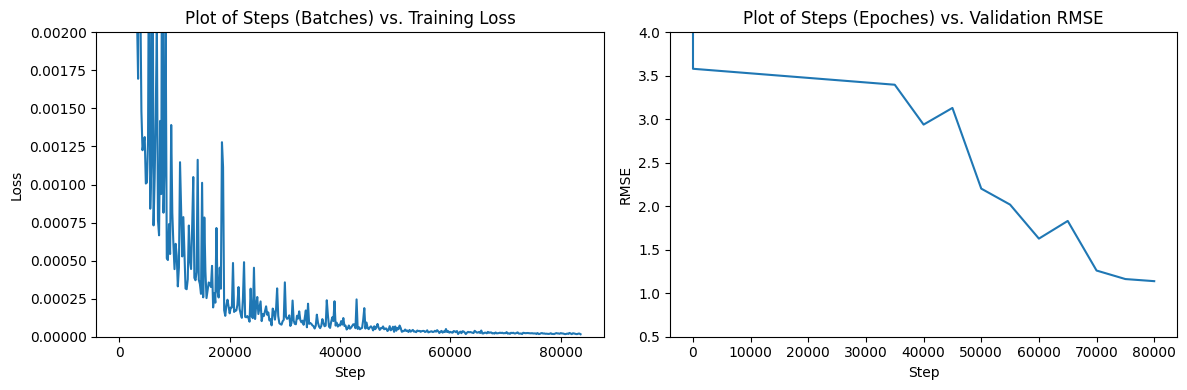

In [25]:
plot_loss("Runs_savio/Nov14_12-41-30_ani1_egtf/train_loss.csv", 0.002,
          "Runs_savio/Nov14_12-41-30_ani1_egtf/valid_rmse.csv", 4)

### Further Runs and Modifications to the model
Attempts to use a dataset comprising up to 6 heavy atoms with energy normalization were also executed, achieving a RMSE loss of approximately 1. However, energy normalization significantly hindered the model's generalizability to datasets containing a higher number of heavy atoms, which the model was not trained on. Consequently, normalization was disabled for future runs. This led to a much broader range of energy values, significantly decreasing the model's ability to learn and predict accurate energies. Using the same model architecture and training parameters as before, the training RMSE converged to around 1, and the validation RMSE to approximately 14. The training curve became much rougher, likely due to large gradient values. Furthermore, the number of epochs required for convergence increased significantly, from 10 to around 25. Subsequent attempts to increase the number of neurons in the feedforward layers of the transformer encoder and in the energy head yielded improved results. The validation loss converged to around 6 using `num_ffn` of 400 and `num_neurons` of 650.

To address the issue of large energy ranges, an additional energy scaling parameter was introduced. This parameter performs simple multiplication/division scaling on the label energy data, and the predicted energies are rescaled back to their "true" values when computing the validation loss. This modification enhanced the model's performance substantially and resulted in a smoother loss curve. Since the training curves are quite different both in terms of convergence epochs, advanced hyperparameter tunings are still being conducted to achieve optimal RMSE loss.

### Run 2. On subset of ANI-1 dataset for up to 6 heavy atoms without energies normalization
```
config_dict = {
    "gpu": "cuda:0", "lr": 2e-4,
    "min_lr": 1e-7, "weight_decay": 0.0,
    "epochs": 15, "warmup_epochs": 1,
    "patience_epochs": 5,
    "log_every_n_steps": 250,
    "scale_value": 300,
    ""
    # "Load_model": None
    "load_model": "models/pretrained_egnn.pth",
    "normalize_energies": False,
    "log_transformation": False,
    "freeze_epochs": 0,  
    "model_dict": {
        "hidden_channels": 256,     # Number of hidden_channels
        "num_edge_feats": 0,        # Number of additional edge features
        "num_egcl": 2,              # Number of EGCL layers
        "act_fn": "SiLU",
        "residual": True,           # Residual calculation
        "attention": True,          # Graph Attention mechanism
        "normalize": True,          # Interatomic distance normalization
        "cutoff": 4,                # Interatomic distance cutoff
        "max_atom_type": 28,        # Max atom types
        "max_num_neighbors": 32,    # Max number of neighborgoods
        "static_coord": True,       # Specify whether to update coord or not
        "freeze_egcl": True,        # Whether or not to freeze weights of egcls 

        # Transformer-Encoder part of the model
        "d_model": 256,             # Embeddings for each token
        "num_encoder": 2,           # Number of encoder units
        "num_heads": 8,             # Number of self-attention heads
        "num_ffn": 256,             # Number of neurons in the feedforward MLP
        "act_fn_ecd": "ReLU",       # Activation function for encoder MLP
        "dropout_r": 0.10,          # Dropout rate

        # Energy Head
        "num_neuron": 512           # NUmber of neurons for the final energy head
    },

    "dataset_dict": {
        "batch_size": 256, "num_workers": 8,
        "valid_size": 0.1, "test_size": 0.1,
        "data_dir": './Data', "seed": 666,
    }
}
```
<i>Total number of parameters: 1,982,979; Total number of trainable (not frozen) parameters: 1,325,570.<br>
Total number of molecular conformations: 3,489,436.</i>

<b>Training was cutoff before finishing full epochs therefore no test data are available. Lowest validation RMSE achieved was 3.10 kcal/mol.</b>

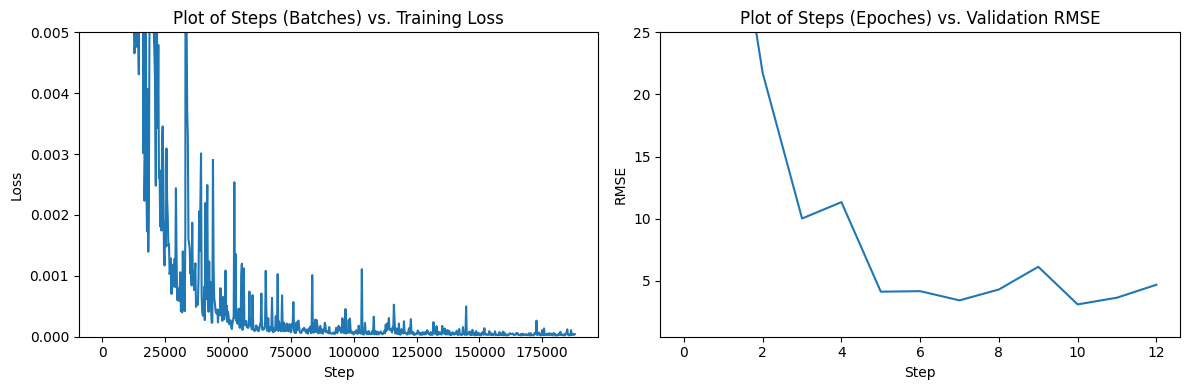

In [26]:
plot_loss("Runs_savio/Nov26_21-03-49_ani1_egtf/train_loss.csv", 0.005,
          "Runs_savio/Nov26_21-03-49_ani1_egtf/valid_rmse.csv", 25)

### Run 3. On subset of ANI-1 dataset for up to 6 heavy atoms without energies normalization
```
config_dict = {
    "gpu": "cuda:0", "lr": 1.8e-4,
    "min_lr": 1e-7, "weight_decay": 0.0,
    "epochs": 18, "warmup_epochs": 1,
    "patience_epochs": 4,
    "log_every_n_steps": 250,
    "scale_value": 300,
    ""
    # "Load_model": None
    "load_model": "models/pretrained_egnn.pth",
    "normalize_energies": False,
    "log_transformation": False,
    "freeze_epochs": 0,  
    "model_dict": {
        "hidden_channels": 256,     # Number of hidden_channels
        "num_edge_feats": 0,        # Number of additional edge features
        "num_egcl": 2,              # Number of EGCL layers
        "act_fn": "SiLU",
        "residual": True,           # Residual calculation
        "attention": True,          # Graph Attention mechanism
        "normalize": True,          # Interatomic distance normalization
        "cutoff": 4,                # Interatomic distance cutoff
        "max_atom_type": 28,        # Max atom types
        "max_num_neighbors": 32,    # Max number of neighborgoods
        "static_coord": True,       # Specify whether to update coord or not
        "freeze_egcl": True,        # Whether or not to freeze weights of egcls 

        # Transformer-Encoder part of the model
        "d_model": 256,             # Embeddings for each token
        "num_encoder": 2,           # Number of encoder units
        "num_heads": 8,             # Number of self-attention heads
        "num_ffn": 256,             # Number of neurons in the feedforward MLP
        "act_fn_ecd": "ReLU",       # Activation function for encoder MLP
        "dropout_r": 0.10,          # Dropout rate

        # Energy Head
        "num_neuron": 512           # NUmber of neurons for the final energy head
    },

    "dataset_dict": {
        "batch_size": 256, "num_workers": 8,
        "valid_size": 0.1, "test_size": 0.1,
        "data_dir": './Data', "seed": 666,
    }
}
```
<i>Total number of parameters: 1,982,979; Total number of trainable (not frozen) parameters: 1,325,570.<br>
Total number of molecular conformations: 3,489,436.</i>
It has been shown in Run2 that the model converges much faster to a lower loss using energies scaling, and the model achieved minimum validation loss at around epoch 10. So in this run, the learning rate has been decreased to 1.8e-4 from 2e-4, the total number of epochs has been decreased to 18, and the number of patience epochs has also been decreased to 4. 

<b>Test RMSE: 1.1049 kcal/mol</b>

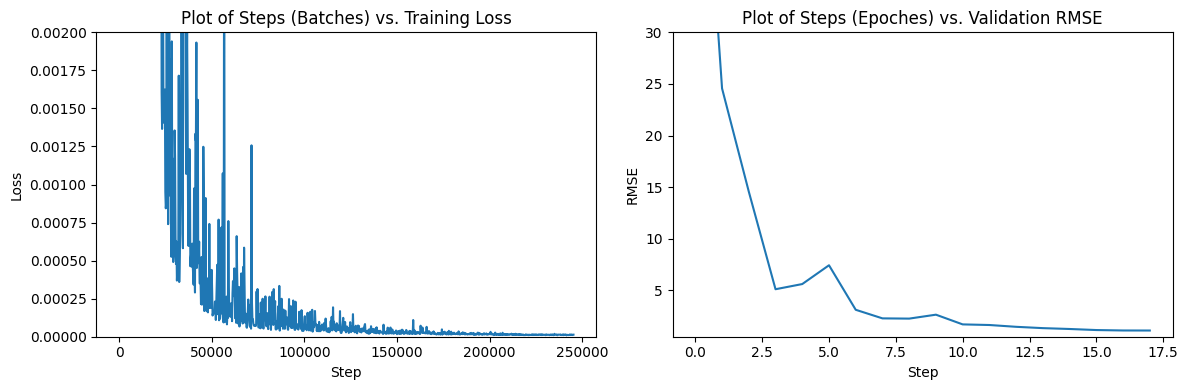

In [5]:
plot_loss("Runs_savio/Nov27_22-03-52_ani1_egtf/train_loss.csv", 0.002,
          "Runs_savio/Nov27_22-03-52_ani1_egtf/valid_rmse.csv", 30)